In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Read in MHC class 1 allele reference set

In [2]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_i.csv'
ref_set_class_i = pd.read_csv(PATH_TO_REF_SET,header=None)

In [3]:
# create a list of alleles
class_i_list = ref_set_class_i[0].tolist()
len(class_i_list)

27

# **Part 1.1**


## Part 1.1.1: Work

In [4]:
# TODO: Create and train a regression model for predicting pIC50 values for the data in MHCI_Binding_Data.csv
# NOTES: 1. You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv
#        2. There are several ways to approach this - please refer to the writeup for ideas/suggestions

In [5]:
# TODO: Create a table where each row corresponds to one of the MHC I binding affinity models above, and
#       the final column is the Coefficient of determination (ie. R^2) of the model using 5-fold cross validation.  

### Data Exploration

In [6]:
# read in data
PATH_TO_MHC1_DATA = 'data/MHCI_Binding_Data.csv'
MHC1_df = pd.read_csv(PATH_TO_MHC1_DATA) 
print(MHC1_df.shape)
MHC1_df.head()

(157325, 6)


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601


In [7]:
# check whether there are other alleles present we don't care about
print(len(MHC1_df['HLA Allele'].unique()))

119


In [8]:
# filter out records which are not for the 27 listed alleles
MHC1_filtered_df = MHC1_df[MHC1_df['HLA Allele'].isin(class_i_list)]
print(MHC1_filtered_df.shape)

# check how much data we have per allele
MHC1_filtered_df['HLA Allele'].value_counts()

(111742, 6)


HLA-A*02:01    12160
HLA-A*03:01     7358
HLA-A*11:01     6399
HLA-A*02:03     6303
HLA-A*31:01     5713
HLA-A*02:06     5628
HLA-A*68:02     5545
HLA-A*01:01     4792
HLA-B*07:02     4642
HLA-A*26:01     4535
HLA-B*15:01     4448
HLA-A*68:01     3795
HLA-A*33:01     3597
HLA-B*08:01     3538
HLA-B*40:01     3443
HLA-B*58:01     3350
HLA-A*24:02     3280
HLA-B*35:01     3211
HLA-A*30:01     2925
HLA-B*57:01     2903
HLA-B*51:01     2901
HLA-A*23:01     2641
HLA-B*44:02     2318
HLA-A*30:02     2057
HLA-B*53:01     1720
HLA-B*44:03     1404
HLA-A*32:01     1136
Name: HLA Allele, dtype: int64

In [9]:
# determine if any of the 27 alleles are not represented
print(len(MHC1_filtered_df['HLA Allele'].value_counts()))

27


In [10]:
# check how much data we have per sequence length
MHC1_filtered_df['peptide_length'].value_counts().sort_index()

8      1854
9     83083
10    24300
11     1668
12      140
13      268
14      168
15      206
17       27
18       27
30        1
Name: peptide_length, dtype: int64

In [11]:
# check whether we have any duplicate rows for a given sequence
MHC1_grouped_df = MHC1_filtered_df.groupby(by=['HLA Allele','sequence']).count()
MHC1_grouped_df = MHC1_grouped_df[MHC1_grouped_df['species'] > 1]
assert MHC1_grouped_df.shape[0] == 0

In [12]:
# check whether there is data for each allele for sequences of only length 9
MHC1_length_9_df = MHC1_filtered_df[MHC1_filtered_df['peptide_length']==9]
print(len(MHC1_length_9_df['HLA Allele'].unique()))
print()

# check how much data we have per sequence length
print(MHC1_length_9_df['peptide_length'].value_counts().sort_index())

# check how much data we have per allele
MHC1_length_9_df['HLA Allele'].value_counts()

27

9    83083
Name: peptide_length, dtype: int64


HLA-A*02:01    9051
HLA-A*03:01    5488
HLA-A*11:01    4544
HLA-A*02:03    4428
HLA-B*15:01    4101
HLA-A*31:01    3945
HLA-A*01:01    3902
HLA-B*07:02    3868
HLA-A*26:01    3766
HLA-A*02:06    3733
HLA-A*68:02    3672
HLA-B*08:01    3027
HLA-B*58:01    2984
HLA-B*40:01    2824
HLA-A*30:01    2565
HLA-B*57:01    2529
HLA-B*35:01    2514
HLA-A*24:02    2395
HLA-B*51:01    2239
HLA-A*68:01    2036
HLA-A*33:01    1929
HLA-A*23:01    1915
HLA-B*44:02    1682
HLA-A*30:02    1330
HLA-B*53:01    1052
HLA-A*32:01     831
HLA-B*44:03     733
Name: HLA Allele, dtype: int64

### Data Prep
Most of the data is concentrated with sequences of length 9 and 10. Let's use only sequences of length 9 to build the regression model.

In [13]:
# read in data
PATH_TO_MHC1_DATA = 'data/MHCI_Binding_Data.csv'
MHC1_df = pd.read_csv(PATH_TO_MHC1_DATA) 

# filter out records with sequence length not equal to 9
MHC1_df = MHC1_df[MHC1_df['peptide_length']==9]

# filter out records which are not for the 27 listed alleles
MHC1_df = MHC1_df[MHC1_df['HLA Allele'].isin(class_i_list)]

MHC1_df.shape

(83083, 6)

### Generate standard sequence lengths
Most of the data is concentrated in the 9 and 10 length range, so it makes sense to build a model based on those lengths. To keep the model simple, we can standardize the length to 9.

- All sequences longer than 9 can be truncated, retaining the first 9 letters.
- Sequences of length < 9 can have a non-coding letter appended for each missing position.

In [14]:
def get_n_length_seq(seq,n):
    '''
    Returns a string of the first n characters of the given sequence.
    
    If given sequence has less than n characters, appends J until
    the desired length has been reached, then returns that string.

    Note that J does not code for a natural amino acid.
    '''
    seq_length = len(seq)
    if seq_length < n:
        # append dummy variable J to make it length n
        addition = (n - seq_length) * 'J'
        result = seq + addition
    else:
        # retain the first 9 characters of sequence
        result = seq[:n]
    return result


In [15]:
# test
print(get_n_length_seq('12345678',10))
print(get_n_length_seq('123456789',9))
print(get_n_length_seq('1234567890',9))

12345678JJ
123456789
123456789


In [16]:
# add a column with the standard 9-length sequence for every record
MHC1_df.loc[:, ('seq_standard')]=MHC1_df.apply(lambda x: get_n_length_seq(x['sequence'],9),axis=1)

MHC1_df.head()

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard
69,human,HLA-A*01:01,9,CSDAFYPFY,1.0,9.0,CSDAFYPFY
70,human,HLA-A*01:01,9,CSDETTLYY,1.0,9.0,CSDETTLYY
71,human,HLA-A*01:01,9,DSDDWLNKY,1.0,9.0,DSDDWLNKY
72,human,HLA-A*01:01,9,EADATWWLY,1.0,9.0,EADATWWLY
73,human,HLA-A*01:01,9,ESDMEVFDY,1.0,9.0,ESDMEVFDY


###  Encode the sequence into feature columns
- Split 9 sequence into one column per letter.
- Use ASCII number for each letter to convert to numerical data to use for regression.

In [17]:
# encode letter as ASCII number
col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9']
MHC1_df[col_list]=MHC1_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))

MHC1_df.head()

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
69,human,HLA-A*01:01,9,CSDAFYPFY,1.0,9.0,CSDAFYPFY,67,83,68,65,70,89,80,70,89
70,human,HLA-A*01:01,9,CSDETTLYY,1.0,9.0,CSDETTLYY,67,83,68,69,84,84,76,89,89
71,human,HLA-A*01:01,9,DSDDWLNKY,1.0,9.0,DSDDWLNKY,68,83,68,68,87,76,78,75,89
72,human,HLA-A*01:01,9,EADATWWLY,1.0,9.0,EADATWWLY,69,65,68,65,84,87,87,76,89
73,human,HLA-A*01:01,9,ESDMEVFDY,1.0,9.0,ESDMEVFDY,69,83,68,77,69,86,70,68,89


### Data Visualization
To help see what type of regression model best fits the data.

In [18]:
from sklearn.decomposition import PCA

def get_allele_data(df,allele):
    '''
    Returns a DataFrame with data only for the given allele.
    '''
    return df[df['HLA Allele'] == allele]


def split_feature_and_target(df):
    '''
    Returns a tuple of (X,y), where X is a DataFrame 
    of the features of the dataset and y is a Series
    of the target.
    
    Features consist only of the sequence columns 
    with individual encoded letters.
    
    Target is the pIC50 column.
    '''
    drop_list = ['species','HLA Allele','peptide_length','sequence','seq_standard','IC50 (nM concentration)', 'pIC50']
    X = df.drop(drop_list,axis=1)
    y = df['pIC50']
    return (X,y)


def visualize_data(df, allele,a1,a2):
#     print(allele,a1,a2)
    X,y = split_feature_and_target(get_allele_data(df,allele))
    rows = X.shape[0]

    if rows > 0:
        # use PCA to visualize data
        pca = PCA(n_components=2)
        pca.fit(X)
        X_pca = pca.transform(X)
        axs[a1,a2].scatter(X_pca[:,0],X_pca[:,1])
    

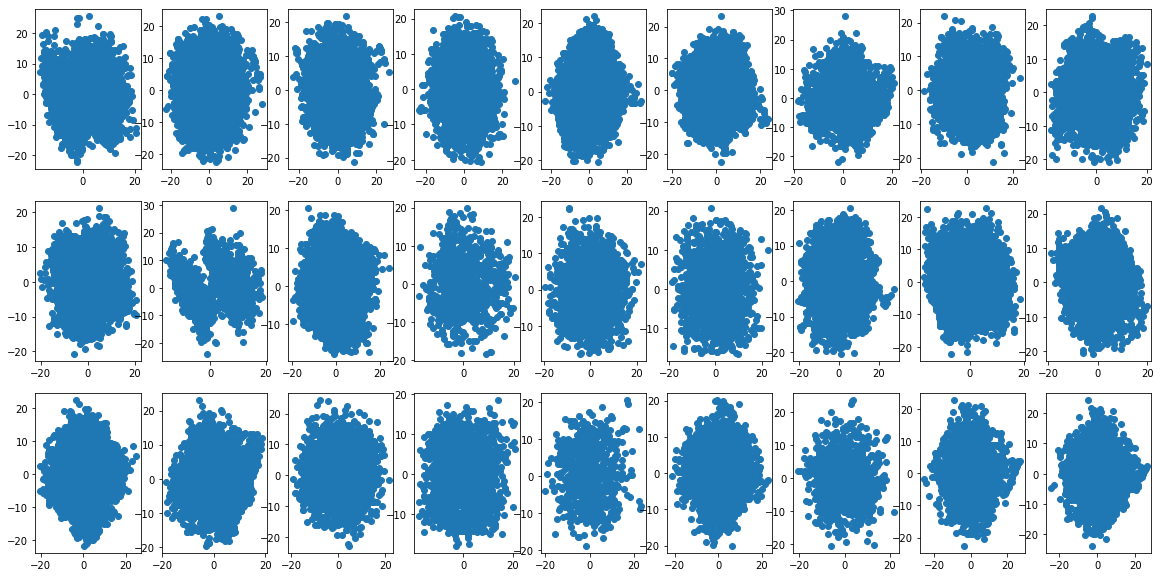

In [19]:
fig, axs = plt.subplots(3,9,figsize=(20,10))

a1 = 0
a2 = 0
for allele in class_i_list:
    if a2 > 8:
        a1 += 1
        a2 = 0
        
    visualize_data(MHC1_df,allele,a1,a2)
    
    a2 += 1


### Train Regression Models
We'll use a linear regression model for each allele. 

Additionally, I'll create a separate model for each allele. There may not be a relationship between the alleles themselves (at least, not the same sort of relationship as the features may have within a single allele). By creating separate models, we prevent any relationship between alleles from manipulating the fit.

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from numpy import mean
from numpy import std

def train_regresson_model(df,allele):
    '''
    Fits a regression model to the data for a 
    given allele and returns the model.
    
    Returns None if no data exists for the given
    allele.
    '''
    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0] # check if data exists for allele
    if rows > 0:
    
        regr = RandomForestRegressor(max_depth=2, random_state=0)
        return regr.fit(X,y)
    
    else:
        return None
    


def score_regression_model(df,allele):
    '''
    Trains a linear regression model on data for
    a given allele, using 5-fold cross validation.
    
    Returns the mean and standard deviation of the
    cross validation scores as a tuple (mean,std_dev).
    
    Returns (0.0,0.0) if no data exists for the given
    allele.
    '''
    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0] # check if data exists for allele
    if rows > 0:
    
        # setup crossfold validation
        cv = KFold(n_splits=5, random_state=1, shuffle=True)   

        # learn model
        regr = RandomForestRegressor(max_depth=2, random_state=0)
        scores = cross_val_score(regr, X, y, scoring='r2', cv=cv)
    
        return (mean(scores),std(scores))
    
    else:
        return (0.0,0.0)


In [21]:
%%time

# for each of the 27 alleles, learn a separate regression model
regression_scores_mhc1 = []
for allele in class_i_list:
    m,s = score_regression_model(MHC1_df,allele)
    result = [allele,round(s,5),round(m,5)] # std_dev before mean
    regression_scores_mhc1.append(result)
    

CPU times: user 22.1 s, sys: 179 ms, total: 22.3 s
Wall time: 22.4 s


In [22]:
mhc1_regression_scores_df = pd.DataFrame(data=regression_scores_mhc1,columns = ['Allele','Std_dev','R_2'])
print(mhc1_regression_scores_df.shape)
mhc1_regression_scores_df


(27, 3)


,Allele,Std_dev,R_2
0,HLA-A*01:01,0.02086,0.35360
1,HLA-A*02:01,0.01320,0.27606
2,HLA-A*02:03,0.01531,0.31211
3,HLA-A*02:06,0.03010,0.17000
4,HLA-A*03:01,0.01229,0.33590
5,HLA-A*11:01,0.02106,0.37462
6,HLA-A*23:01,0.02401,0.29890
7,HLA-A*24:02,0.04354,0.28921
8,HLA-A*26:01,0.01598,0.18308
9,HLA-A*30:01,0.03722,0.15079


## Part 1.1.1: Answer

Briefly describe your approach for creating the regression model: **YOUR EXPLANATION HERE**

**Include the table as the output of the cell above or embed it as an image in this cell**

## Part 1.1.2: Work

In [23]:
# TODO: Create and train a regression model for predicting pIC50 values for the data in MHCII_Binding_Data.csv
# NOTES: 1. You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv
#        2. There are several ways to approach this - please refer to the writeup for ideas/suggestions

In [24]:
# TODO: Create a table where each row corresponds to one of the MHC II binding affinity models above, and
#       the final column is the Coefficient of determination (ie. R^2) of the model using 5-fold cross validation.  

### Read in MHC class 2 allele reference set

In [25]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_ii.csv'
ref_set_class_ii = pd.read_csv(PATH_TO_REF_SET,header=None)

In [26]:
# create a list of alleles
class_ii_list = ref_set_class_ii[0].tolist()
len(class_ii_list)

27

### Data Exploration

In [27]:
# read in data
PATH_TO_MHC2_DATA = 'data/MHCII_Binding_Data.csv'
MHC2_df = pd.read_csv(PATH_TO_MHC2_DATA) 
print(MHC2_df.shape)
MHC2_df.head()

(44914, 6)


,species,mhc,peptide_length,sequence,IC50 (nM concentration),pIC50
0,human,HLA-DPA1*01/DPB1*0401,15,AKKYFAATQFEPLAA,1.000000,9.000000
1,human,HLA-DPA1*01/DPB1*0401,15,AWVDSGAQLGELYYA,8389.261745,5.076276
2,human,HLA-DPA1*01/DPB1*0401,15,KRVSNVIIHGLHLYG,2429.149798,5.614546
3,human,HLA-DPA1*01/DPB1*0401,15,PATPAAPGAGYTPAT,24793.388430,4.605664
4,human,HLA-DPA1*01/DPB1*0401,15,EKMYFAATQFEPLAA,1.000000,9.000000


In [28]:
# rename allele column to match MHC1 data
MHC2_df = MHC2_df.rename(columns={"mhc": "HLA Allele"})

In [29]:
# check whether there are other alleles present we don't care about
print(len(MHC2_df['HLA Allele'].unique()))

26


In [30]:
# filter out records which are not for the 27 listed alleles
MHC2_filtered_df = MHC2_df[MHC2_df['HLA Allele'].isin(class_ii_list)]
print(MHC2_filtered_df.shape)

# check how much data we have per allele
MHC2_filtered_df['HLA Allele'].value_counts()

(43000, 6)


HLA-DRB1*0101              6427
HLA-DRB1*1101              1794
HLA-DRB5*0101              1769
HLA-DRB1*1501              1769
HLA-DRB1*0401              1769
HLA-DRB1*0701              1745
HLA-DQA1*0101/DQB1*0501    1739
HLA-DQA1*0301/DQB1*0302    1719
HLA-DRB1*0301              1715
HLA-DQA1*0401/DQB1*0402    1701
HLA-DQA1*0501/DQB1*0301    1689
HLA-DQA1*0501/DQB1*0201    1658
HLA-DQA1*0102/DQB1*0602    1629
HLA-DRB1*0405              1582
HLA-DRB1*1302              1580
HLA-DRB4*0101              1521
HLA-DRB1*0802              1520
HLA-DRB1*0901              1520
HLA-DRB3*0101              1501
HLA-DPA1*0201/DPB1*0501    1410
HLA-DPA1*0301/DPB1*0402    1407
HLA-DPA1*0103/DPB1*0201    1404
HLA-DPA1*0201/DPB1*0101    1399
HLA-DPA1*0103/DPB1*0401    1033
Name: HLA Allele, dtype: int64

In [31]:
# determine if any of the 27 alleles are not represented
print(len(MHC2_filtered_df['HLA Allele'].value_counts()))

# determine which are missing
included = list(MHC2_filtered_df['HLA Allele'].value_counts().index)
missing = [each for each in class_ii_list if each not in included]
missing

24


['HLA-DRB1*1201', 'HLA-DRB3*0202', 'HLA-DPA1*0201/DPB1*1401']

In [32]:
# check how much data we have per sequence length
MHC2_filtered_df['peptide_length'].value_counts().sort_index()

9        17
10       89
11      116
12       78
13      425
14      352
15    40106
16     1092
17      348
18      106
19      121
20      120
21       18
23        4
37        8
Name: peptide_length, dtype: int64

In [33]:
# check whether we have any duplicate rows for a given sequence
MHC2_grouped_df = MHC2_filtered_df.groupby(by=['HLA Allele','sequence']).count()
MHC2_grouped_df = MHC2_grouped_df[MHC2_grouped_df['species'] > 1]
assert MHC2_grouped_df.shape[0] == 0

In [34]:
# check whether there is data for each allele for sequences of only length 15
MHC2_length_15_df = MHC2_filtered_df[MHC2_filtered_df['peptide_length']==15]
print(len(MHC2_length_15_df['HLA Allele'].unique()))
print()

# check how much data we have per sequence length
print(MHC2_length_15_df['peptide_length'].value_counts().sort_index())

# check how much data we have per allele
MHC2_length_15_df['HLA Allele'].value_counts()

24

15    40106
Name: peptide_length, dtype: int64


HLA-DRB1*0101              6340
HLA-DRB1*1101              1701
HLA-DRB1*0401              1699
HLA-DRB5*0101              1684
HLA-DRB1*1501              1684
HLA-DRB1*0701              1675
HLA-DRB1*0301              1658
HLA-DQA1*0401/DQB1*0402    1579
HLA-DQA1*0501/DQB1*0301    1573
HLA-DQA1*0102/DQB1*0602    1515
HLA-DRB1*0405              1512
HLA-DRB1*1302              1511
HLA-DRB1*0802              1498
HLA-DRB1*0901              1498
HLA-DRB4*0101              1498
HLA-DRB3*0101              1463
HLA-DQA1*0101/DQB1*0501    1306
HLA-DPA1*0301/DPB1*0402    1293
HLA-DPA1*0103/DPB1*0201    1292
HLA-DQA1*0501/DQB1*0201    1290
HLA-DPA1*0201/DPB1*0501    1287
HLA-DQA1*0301/DQB1*0302    1286
HLA-DPA1*0201/DPB1*0101    1285
HLA-DPA1*0103/DPB1*0401     979
Name: HLA Allele, dtype: int64

### Data Prep
Most of the data is concentrated with sequences of length 15. Let's use only sequences of length 15 to build the regression model.

In [35]:
# read in data
PATH_TO_MHC2_DATA = 'data/MHCII_Binding_Data.csv'
MHC2_df = pd.read_csv(PATH_TO_MHC2_DATA) 

# rename allele column to match MHC1 data
MHC2_df = MHC2_df.rename(columns={"mhc": "HLA Allele"})

# filter out records with sequence length not equal to 15
MHC2_df = MHC2_df[MHC2_df['peptide_length']==15]

# filter out records which are not for the 27 listed alleles
MHC2_df = MHC2_df[MHC2_df['HLA Allele'].isin(class_ii_list)]

MHC2_df.shape

(40106, 6)

### Generate standard sequence lengths
Most of the data is concentrated in the 15 length range, so it makes sense to build a model based on that length. To keep the model simple, we can standardize the length to 15.

- All sequences longer than 15 can be truncated, retaining the first 15 letters.
- Sequences of length < 15 can have a non-coding letter appended for each missing position.

In [36]:
# add a column with the 15-length sequence for every record
MHC2_df.loc[:, ('seq_standard')]=MHC2_df.apply(lambda x: get_n_length_seq(x['sequence'],15),axis=1)

MHC2_df.head()

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard
1337,human,HLA-DPA1*0103/DPB1*0201,15,EKKYFAATCFEPLAA,1.000000,9.000000,EKKYFAATCFEPLAA
1338,human,HLA-DPA1*0103/DPB1*0201,15,EKKYLAATQFEPLAA,1.186663,8.925673,EKKYLAATQFEPLAA
1339,human,HLA-DPA1*0103/DPB1*0201,15,FTVFEAAFNNAIKAG,1176.286073,5.929487,FTVFEAAFNNAIKAG
1340,human,HLA-DPA1*0103/DPB1*0201,15,ATTEEQKLIEDINAS,7907.221929,5.101976,ATTEEQKLIEDINAS
1341,human,HLA-DPA1*0103/DPB1*0201,15,HPQDGDALTLRTATN,16722.408030,4.776701,HPQDGDALTLRTATN


###  Encode the sequence into feature columns
- Split 15 sequence into one column per letter.
- Use ASCII number for each letter to convert to numerical data to use for regression.

In [37]:
# encode letter as ASCII number
col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15']
MHC2_df[col_list]=MHC2_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))

MHC2_df.head()

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,...,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15
1337,human,HLA-DPA1*0103/DPB1*0201,15,EKKYFAATCFEPLAA,1.000000,9.000000,EKKYFAATCFEPLAA,69,75,75,...,65,65,84,67,70,69,80,76,65,65
1338,human,HLA-DPA1*0103/DPB1*0201,15,EKKYLAATQFEPLAA,1.186663,8.925673,EKKYLAATQFEPLAA,69,75,75,...,65,65,84,81,70,69,80,76,65,65
1339,human,HLA-DPA1*0103/DPB1*0201,15,FTVFEAAFNNAIKAG,1176.286073,5.929487,FTVFEAAFNNAIKAG,70,84,86,...,65,65,70,78,78,65,73,75,65,71
1340,human,HLA-DPA1*0103/DPB1*0201,15,ATTEEQKLIEDINAS,7907.221929,5.101976,ATTEEQKLIEDINAS,65,84,84,...,81,75,76,73,69,68,73,78,65,83
1341,human,HLA-DPA1*0103/DPB1*0201,15,HPQDGDALTLRTATN,16722.408030,4.776701,HPQDGDALTLRTATN,72,80,81,...,68,65,76,84,76,82,84,65,84,78


### Data Visualization
To help see what type of regression model best fits the data.

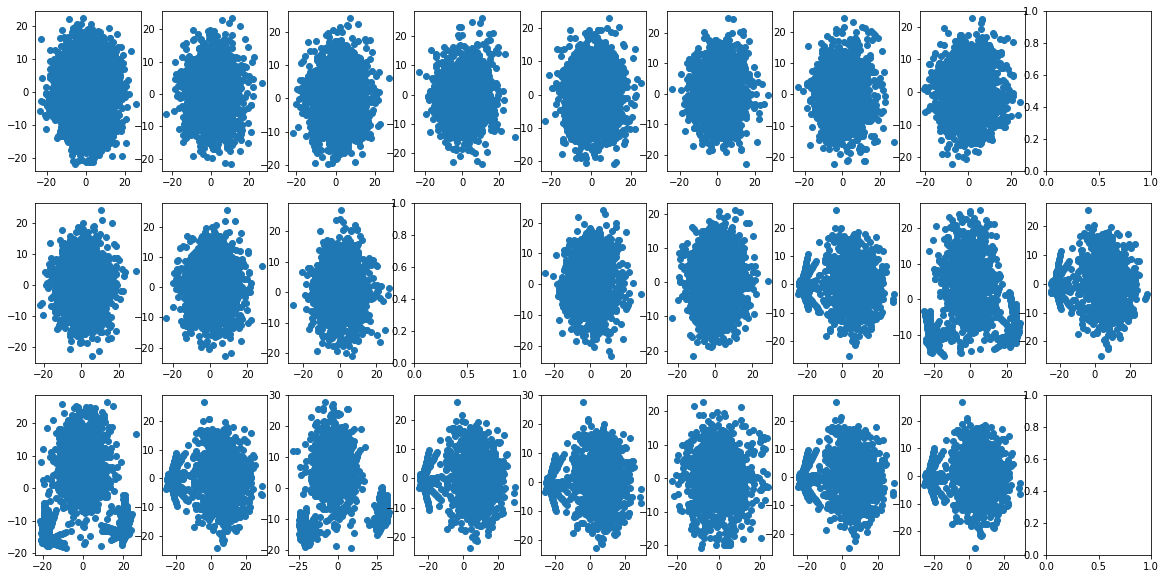

In [38]:
fig, axs = plt.subplots(3,9,figsize=(20,10))

a1 = 0
a2 = 0

for allele in class_ii_list:
    
    if a2 > 8:
        a1 += 1
        a2 = 0
        
    visualize_data(MHC2_df,allele,a1,a2)
    
    a2 += 1


In [39]:
%%time

# for each of the 27 alleles, learn a separate regression model
regression_scores_mhc2 = []
for allele in class_ii_list:
    m,s = score_regression_model(MHC2_df,allele)
    result = [allele,round(s,5),round(m,5)] # std_dev before mean
    regression_scores_mhc2.append(result)

CPU times: user 18.9 s, sys: 180 ms, total: 19.1 s
Wall time: 19.2 s


In [40]:
mhc2_regression_scores_df = pd.DataFrame(data=regression_scores_mhc2,columns = ['Allele','Std_dev','R_2'])
print(mhc2_regression_scores_df.shape)
mhc2_regression_scores_df


(27, 3)


,Allele,Std_dev,R_2
0,HLA-DRB1*0101,0.00681,0.03898
1,HLA-DRB1*0301,0.01134,0.05103
2,HLA-DRB1*0401,0.00723,0.04783
3,HLA-DRB1*0405,0.01512,0.05965
4,HLA-DRB1*0701,0.00835,0.06770
5,HLA-DRB1*0802,0.00459,0.03301
6,HLA-DRB1*0901,0.01660,0.01775
7,HLA-DRB1*1101,0.01132,0.07161
8,HLA-DRB1*1201,0.00000,0.00000
9,HLA-DRB1*1302,0.01044,0.04899


## Part 1.1.2: Answer

Briefly describe your approach for creating the regression model: **YOUR EXPLANATION HERE**

**Include the table as the output of the cell above or embed it as an image in this cell**

# Part 1.2

## Part 1.2: Work 

### Read spike sequence

In [41]:
# TIP: The .fasta files usually start with some header describing the meta information. 
#      The code below skips the header and joins the lines of the sequence to obtain
#      the full protein sequence

In [42]:
def get_spike_sequence(filename):
    '''
    Reads file in FASTA format and returns 
    the sequence as a string.
    '''
  
    with open(PATH_TO_FASTA) as f:
        sequence = ''.join(f.read().split('\n')[1:])   
        return sequence
    
    
def get_spike_array(sequence):
    '''
    Returns a numpy character array of the given sequence.
    '''
    return np.array([char for char in sequence])

In [43]:
# build character array of full sequence
PATH_TO_FASTA = 'data/SARS-CoV2-Spike.fasta' 
spike_sequence = get_spike_sequence(PATH_TO_FASTA)
spike_array = get_spike_array(spike_sequence)
assert len(spike_sequence) == len(spike_array)
len(spike_array)

1273

### Split spike sequence into k-mers
My method is to use a generator to return k-mers one at a time, rather than need to store all k-mers in a data structure. The generator terminates when there all k-mers have been generated.

In [44]:
# TODO: Split protein sequence from SARS-CoV2-Spike.fasta into 
# overlapping k-mers for your choice of k 

In [45]:
def split_spike_sequence(seq,k):
    '''
    Returns a generator for k-mers.
    
    Each iteration of the generator returns a tuple containing
    the next k-mer of the sequence in following form:
    (start index, end index, k-mer)
    '''
    
    start = 0
    end = start + (k-1)
    last_position = len(seq) - 1

    while end <= last_position:
        
        yield (start,end,seq[start:end+1])
        
        # get next sequence
        start = start + 1
        end = start + (k-1)


def get_sequence_string(seq):
    '''
    Returns a string of the given sequence.
    '''
    return ''.join(seq.tolist())
    

In [46]:
print('test split_spike_sequence()')

print(spike_array[:12])
print()
for each in split_spike_sequence(spike_array[:12],9):
    print(each)


test split_spike_sequence()
['M' 'F' 'V' 'F' 'L' 'V' 'L' 'L' 'P' 'L' 'V' 'S']

(0, 8, array(['M', 'F', 'V', 'F', 'L', 'V', 'L', 'L', 'P'], dtype='<U1'))
(1, 9, array(['F', 'V', 'F', 'L', 'V', 'L', 'L', 'P', 'L'], dtype='<U1'))
(2, 10, array(['V', 'F', 'L', 'V', 'L', 'L', 'P', 'L', 'V'], dtype='<U1'))
(3, 11, array(['F', 'L', 'V', 'L', 'L', 'P', 'L', 'V', 'S'], dtype='<U1'))


In [47]:
print('test get_sequence_string()')

get_sequence_string(np.array(['M','F','V']))

test get_sequence_string()


'MFV'

## Part 1.2: Answer

What was the value of k you used to create the overlapping k-mers? **For MHC I data, I used a value of k=9. For MHC II data, I used a value of k=15.**

# Part 1.3

## Part 1.3: Work

In [48]:
# TODO: 1. Apply the models you created in part 1.1 to the k-mers you created in part 1.2.  
#       2. Store the returned labeled (MHC, peptide) pairs where the label is the predicted pIC50 value
#       3. Determine the min, max, mean, median, and std. dev of the predicted pIC50 values for each MHC class

### Define algorithm for estimating pIC50 for Spike Protein k-mers
Generate a set of labeled (MHC,peptide) pairs, where the label is the predicted pIC50 value.

In [71]:
def encode_seq(sequence):
    '''
    Converts numpy character array to numpy integer array
    where each character is the ASCII encoded value.
    '''
    encoder = lambda t: ord(t)
    vfunc = np.vectorize(encoder)
    return vfunc(sequence)    
    
    
def split_into_features(seq):
    '''
    Takes an encoded sequence and returns a 
    DataFrame with each element as its own
    column.
    '''
    return pd.DataFrame(seq).T


def get_pIC50_from_data(df,allele,sequence):
    '''
    Checks given DataFrame for a row with the given allele
    and sequence. Returns pIC50 value if a matching row is
    found, returns None otherwise.
    '''
    
    # find all matches in DataFrame for given allele and sequence
    matches = df[(df['HLA Allele'] == allele) & (df['seq_standard'] == sequence)]
    
    if matches.shape[0] > 0:
        
        #take the first match and extract the pIC50 value from it
        pIC50 = matches['pIC50'].iloc[0]
        
    else:
    
        pIC50 = None
    
    return pIC50


def predict_pIC50_values_for_allele(pIC50_df, model, allele, spike_array, k):
    '''
    Given a regression model, allele, spike sequence array, 
    and k-mer length, returns a list of pIC50 predictions in 
    the form of a tuple (allele,peptide,start,end,pIC50).
    
    If an exact sequence match is found in the pIC50 data itself,
    uses that pIC50 value instead of predicting a value.
    '''
    results = []
    
    # executes once for each k-mer in the sequence
    for start,end,arr in split_spike_sequence(spike_array,k):
        
        # determine if the k-mer exists in the data
        peptide = get_sequence_string(arr)
        pIC50 = get_pIC50_from_data(pIC50_df,allele,peptide)
        
        if not pIC50:

            # predict the pIC50 value
            encoded = encode_seq(arr)
            features = split_into_features(encoded)
            pIC50 = model.predict(features)[0]

        # save result 
        results.append((allele,peptide,start,end,pIC50))  
        
    return results


In [50]:
print('test encode_seq()')

print(spike_array[:4])
print(encode_seq(spike_array[:4]))
for each in encode_seq(spike_array[:4]):
    print(chr(each))

test encode_seq()
['M' 'F' 'V' 'F']
[77 70 86 70]
M
F
V
F


In [51]:
print('test split_into_features()')
print(spike_array[:4])
split_into_features(encode_seq(spike_array[:4]))

test split_into_features()
['M' 'F' 'V' 'F']


,0,1,2,3
0,77,70,86,70


In [52]:
print('test get_pIC50_from_data()')

# match exists
print(get_pIC50_from_data(MHC1_df,'HLA-A*01:01','CVADYSVLY'))

MHC1_df[(MHC1_df['HLA Allele'] == 'HLA-A*01:01') & (MHC1_df['seq_standard'] == 'CVADYSVLY')]

test get_pIC50_from_data()
7.874116247000001


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
223,human,HLA-A*01:01,9,CVADYSVLY,13.362378,7.874116,CVADYSVLY,67,86,65,68,89,83,86,76,89


In [53]:
# match doesn't exist
seq = get_spike_array('CVADYSVLY')
print(get_pIC50_from_data(MHC1_df,'HLA-A*02:01','CVADYSVLY'))

None


In [54]:
print('test predict_pIC50_values_for_allele()')

test_df = MHC1_df[MHC1_df['seq_standard'] == 'CVADYSVLY']
print(test_df.shape)

# train model for this allele
test_model = train_regresson_model(MHC1_df,'HLA-A*01:01')

test_results = predict_pIC50_values_for_allele(test_df, test_model, 'HLA-A*01:01', spike_array, 9)

test predict_pIC50_values_for_allele()
(5, 16)


In [55]:
for each in test_results:
    if round(each[4],2) == 7.87:
        print(each)

('HLA-A*01:01', 'CVADYSVLY', 360, 368, 7.874116247000001)


In [73]:
def predict_pIC50_values(allele_list, df, seq, k):
    '''
    For each allele in the allele list, trains a regression
    model using the given DataFrame, then uses that model to 
    predict pIC50 for each k-mer in the given protein sequence.
    
    Returns a list of all results.
    '''
    
    results = []

    for allele in allele_list:
        
        print('.',end='') # visualizing progress
    
        # train model for this allele
        model = train_regresson_model(df,allele)
        
        # use model as long as it is not None
        if model:

            # predict pIC50 for each k-mer in the sequence
            result = predict_pIC50_values_for_allele(df,model,allele,seq,k)
            results = results + result
            
    print() # newline for visualization
    return results


In [74]:
print('test predict_pIC50_values()')

# test for 2 k-mers to ensure the correct number of results are found
test_array = spike_array[359:369]
print(test_array)

test_alleles = class_i_list[:2]
print(test_alleles)

test_results = predict_pIC50_values(test_alleles,MHC1_df,test_array,9)
print(len(test_results))

test predict_pIC50_values()
['N' 'C' 'V' 'A' 'D' 'Y' 'S' 'V' 'L' 'Y']
['HLA-A*01:01', 'HLA-A*02:01']
..
4


In [75]:
test_results

[('HLA-A*01:01', 'NCVADYSVL', 0, 8, 4.691983176635914),
 ('HLA-A*01:01', 'CVADYSVLY', 1, 9, 7.874116247000001),
 ('HLA-A*02:01', 'NCVADYSVL', 0, 8, 5.292583412663456),
 ('HLA-A*02:01', 'CVADYSVLY', 1, 9, 5.3770656045923655)]

In [76]:
# test for MHC II to ensure the correct number of results are found
# 3 alleles currently have no data so there should be 48 results

test_array = spike_array[:16]
test_results = predict_pIC50_values(class_ii_list,MHC2_df,test_array,15)
print(len(test_results))

...........................

48


### Apply pIC50 Algorithm to MHC I  data

In [77]:
%%time

# 9 min for RandomForest with max_depth=2, random_state=0
results_mhc1 = predict_pIC50_values(class_i_list,MHC1_df,spike_array,9)

...........................
CPU times: user 9min 4s, sys: 2.6 s, total: 9min 6s
Wall time: 9min 9s


In [78]:
# validate result

# There are 1265 9-mers over sequence of 1273 letters
expected = 27 * 1265
actual = len(results_mhc1)
assert expected == actual,actual

In [79]:
# check whether results are reasonable
for each in results_mhc1:
    if each[1] == 'CVADYSVLY':
        print(each)

('HLA-A*01:01', 'CVADYSVLY', 360, 368, 7.874116247000001)
('HLA-A*02:01', 'CVADYSVLY', 360, 368, 5.3770656045923655)
('HLA-A*02:03', 'CVADYSVLY', 360, 368, 5.220575851750908)
('HLA-A*02:06', 'CVADYSVLY', 360, 368, 5.087162087083698)
('HLA-A*03:01', 'CVADYSVLY', 360, 368, 5.340607655234088)
('HLA-A*11:01', 'CVADYSVLY', 360, 368, 5.475690080494777)
('HLA-A*23:01', 'CVADYSVLY', 360, 368, 4.245378088)
('HLA-A*24:02', 'CVADYSVLY', 360, 368, 4.11021548)
('HLA-A*26:01', 'CVADYSVLY', 360, 368, 9.0)
('HLA-A*30:01', 'CVADYSVLY', 360, 368, 5.025737213120219)
('HLA-A*30:02', 'CVADYSVLY', 360, 368, 7.415541367)
('HLA-A*31:01', 'CVADYSVLY', 360, 368, 4.893925228428852)
('HLA-A*32:01', 'CVADYSVLY', 360, 368, 5.326367967120417)
('HLA-A*33:01', 'CVADYSVLY', 360, 368, 4.621358255429664)
('HLA-A*68:01', 'CVADYSVLY', 360, 368, 5.525344377018525)
('HLA-A*68:02', 'CVADYSVLY', 360, 368, 5.2114482598819105)
('HLA-B*07:02', 'CVADYSVLY', 360, 368, 4.892958847735635)
('HLA-B*08:01', 'CVADYSVLY', 360, 368, 4.7320

### Apply pIC50 Algorithm to MHC II  data

In [154]:
%%time

# 6 min for RandomForest with max_depth=2, random_state=0

results_mhc2 = predict_pIC50_values(class_ii_list,MHC2_df,spike_array,15)

...........................
CPU times: user 5min 52s, sys: 1.68 s, total: 5min 54s
Wall time: 5min 55s


In [156]:
# validate result

# There are 1259 15-mers over sequence of 1273 letters
# 3 alleles have no data
expected = 24 * 1259
actual = len(results_mhc2)
assert expected == actual,actual

### Calculate metrics for table

In [80]:
from numpy import min,max,median

def calculate_metrics(mhc_class, predictions):
    '''
    Calculates min, max, mean, median, and standard deviation
    of all results for a given MHC class.
    
    Returns the metrics in a tuple with the form:
    (min, max, mean, median, std_dev)
    '''

    # create numpy array of the pIC50 values
    a = np.array([t[4] for t in predictions])
    
    return [mhc_class, np.min(a),np.max(a),np.mean(a),np.median(a),np.std(a)]
    

In [81]:
# test
print(np.array([t[4] for t in test_results]))
calculate_metrics('II',test_results)

[6.81316398 6.79457858 5.60903332 5.66663906 6.43734415 6.28541366
 6.3520063  6.25749806 6.60256851 6.28425349 5.83451224 5.82003082
 6.21125286 6.19710611 6.4326566  6.43875516 5.67841488 6.03209714
 6.31257505 6.07294111 5.53549888 5.48000533 5.87698486 6.14698111
 6.58037439 6.22812115 5.30457438 5.26418905 6.1827245  5.98976333
 5.31108057 5.30127559 5.28062007 5.27592499 5.11264134 5.05461599
 5.79851754 6.28828727 5.66655422 5.70341455 5.60974501 5.60974501
 5.25151946 5.26010174 5.60836924 5.61349188 5.27830951 5.35637769]


['II',
 5.054615990417661,
 6.813163977781531,
 5.8563052023275475,
 5.8092741781798605,
 0.47503857818795864]

In [157]:
# calculate metrics for MHC I
mch1_metrics = calculate_metrics('I',results_mhc1)

# calculate metrics for MHC II
mch2_metrics = calculate_metrics('II',results_mhc2)

# format results into a table
data_1_3 = [mch1_metrics,mch2_metrics]
df_1_3 = pd.DataFrame(data=data_1_3,columns = ['MHC Class','Min','Max','Mean','Median','Std Dev'])
df_1_3

,MHC Class,Min,Max,Mean,Median,Std Dev
0,I,3.970037,9.0,5.190039,5.076415,0.521639
1,II,4.955908,9.0,5.837599,5.798518,0.460943


## Part 1.3: Answer

If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of the above cell as long as it contains all of the relevant information.

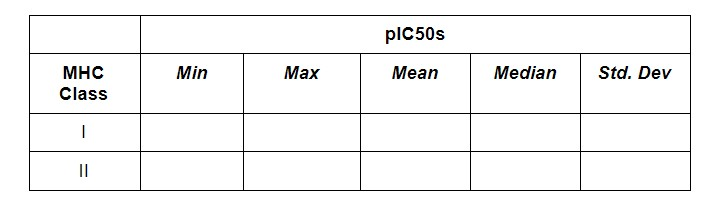

# Part 1.4

## Part 1.4: Work

In [ ]:
# TODO: 1. Devise and implement an algorithm for selecting SARS-CoV-2 peptides from the set you created in part 1.3 that maximizes the ‘allele coverage’
#       (Please refer to the write-up for definitions and constraints)
#       2. Use your algorithm to compute the values required for the tables in the cell below

### Min Selection Algorithm Part 1 - Build Coverage DataFrame
- Limit choices to peptides with pIC50 value greater than p_min
- Create a DataFrame which lists 
  - peptide
  - start position
  - end position
  - for each allele, flag which denotes if the allele is covered by this peptide
  - count column which sums all allele flags for this peptide

In [84]:
def get_list_above_p_min(predictions,p_min):
    '''
    Returns a list of predictions which have a pIC50 value above p_min.
    '''
    
    results = []
    
    for prediction in predictions:
        pIC50 = prediction[4]
        if pIC50 >= p_min:
            results.append(prediction)
    
    return results


def get_peptide_coverage_dict(predictions_list):
    '''
    Builds and returns a dictionary in which keys are every 
    peptide in the prediction list and the value for each 
    key is a set of alleles which are covered by that peptide.
    '''
    
    # maintain a set of peptides which cover each allele
    coverage_dict = dict()

    for allele,peptide,start,end,pIC50 in predictions_list:
        
        # define key to avoid collisions
        key = peptide + '_' + str(start) + '_' + str(end)
        
        if key in coverage_dict:
            # append allele to the list
            coverage_dict[key].add(allele)
        else:
            # add set to dictionary
            new_set = set()
            new_set.add(allele)
            coverage_dict[key] = new_set
     
    return coverage_dict


def build_row_df(coverage_dict,key,alleles):
    '''
    Builds and returns a DataFrame consisting of a single row
    with the following columns:
    
    - peptide
    - start position
    - end position
    - allele flag for each allele in alleles
    - count
    
    Allele flag is 1 if allele binds with this peptide,
    0 otherwise.
    
    Count is a sum of all allele flags for this peptide 
    '''
    
    peptide,start,end=key.split('_')

    new_dict = dict()
    new_dict['peptide']=[peptide]
    new_dict['start']=[int(start)]
    new_dict['end']=[int(end)]

    # create row for DataFrame of all alleles
    counter = 0
    for allele in alleles:

        if allele in coverage_dict[key]:
            new_dict[allele] = [1]
            counter += 1
        else:
            new_dict[allele] = [0]

    new_dict['count'] = [counter]
    return pd.DataFrame.from_dict(new_dict)
    

def build_peptide_coverage_df(coverage_dict,alleles):
    '''
    Builds and returns a DataFrame which contains a row for 
    each peptide in the coverage dictionary with columns
    for each allele in alleles.
    '''
    
    counter = 0
    df = None
    for key in coverage_dict:
        
        # build row
        df_row = build_row_df(coverage_dict,key,alleles)
        
        if counter == 0:
            df = df_row
        else:
            df = df.append(df_row)
        
        counter += 1
    return df


def get_peptide_coverage_df(predictions_list,p_min,alleles):
    '''
    Selects from the given predictions list those
    peptides which have pIC50 at or above p_min, then
    builds a DataFrame representing the allele coverage
    for each of the selected peptides.
    '''
    above = get_list_above_p_min(predictions_list,p_min)
    if len(above) > 0:
        p_dict = get_peptide_coverage_dict(above)
        df = build_peptide_coverage_df(p_dict, alleles)
    else:
        df = pd.DataFrame() # empty DataFrame
    return df
    

In [87]:
print('get_list_above_p_min()')
print(len(results_mhc1))
print()
print(len(get_list_above_p_min(results_mhc1,9.0)))
print(len(get_list_above_p_min(results_mhc1,8.0)))
print(len(get_list_above_p_min(results_mhc1,7.0)))
print(len(get_list_above_p_min(results_mhc1,6.0)))
print(len(get_list_above_p_min(results_mhc1,5.0)))
print(len(get_list_above_p_min(results_mhc1,4.0)))
print(len(get_list_above_p_min(results_mhc1,3.0)))

get_list_above_p_min(results_mhc1,9.0)

get_list_above_p_min()
34155

4
15
313
2335
19696
34154
34155


[('HLA-A*02:03', 'VVFLHVTYV', 1059, 1067, 9.0),
 ('HLA-A*02:03', 'FIAGLIAIV', 1219, 1227, 9.0),
 ('HLA-A*26:01', 'CVADYSVLY', 360, 368, 9.0),
 ('HLA-A*68:02', 'FIAGLIAIV', 1219, 1227, 9.0)]

In [90]:
print('test get_peptide_coverage_dict()')
test_above = get_list_above_p_min(results_mhc1,9.0)

test_d = get_peptide_coverage_dict(test_above)
test_d

test get_peptide_coverage_dict()


{'VVFLHVTYV_1059_1067': {'HLA-A*02:03'},
 'FIAGLIAIV_1219_1227': {'HLA-A*02:03', 'HLA-A*68:02'},
 'CVADYSVLY_360_368': {'HLA-A*26:01'}}

In [92]:
print('test build_row_df()')
test_row = build_row_df(test_d,'FIAGLIAIV_1219_1227',class_i_list)
test_row.T

test build_row_df()


,0
peptide,FIAGLIAIV
start,1219
end,1227
HLA-A*01:01,0
HLA-A*02:01,0
HLA-A*02:03,1
HLA-A*02:06,0
HLA-A*03:01,0
HLA-A*11:01,0
HLA-A*23:01,0


In [104]:
print('test build_peptide_coverage_df()')

test_coverage_df = build_peptide_coverage_df(test_d, class_i_list)
test_coverage_df

test build_peptide_coverage_df()


,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,VVFLHVTYV,1059,1067,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,FIAGLIAIV,1219,1227,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,CVADYSVLY,360,368,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [105]:
print('test get_peptide_coverage_df()')

test_coverage_df = get_peptide_coverage_df(results_mhc1,10.0,class_i_list)
print(len(test_coverage_df))

test_coverage_df = get_peptide_coverage_df(results_mhc1,9.0,class_i_list)
test_coverage_df

test get_peptide_coverage_df()
0


,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,VVFLHVTYV,1059,1067,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,FIAGLIAIV,1219,1227,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,CVADYSVLY,360,368,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Min Selection Algorithm Part 2 - Select Peptides for Minimum Coverage
Choose peptides which cover as many alleles as possible.

In [97]:
# check coverage of alleles mhc 1

for p_min in [3.0,6.0,9.0]:
    mhc1_coverage_df = get_peptide_coverage_df(results_mhc1,p_min,class_i_list)
    a = pd.DataFrame(mhc1_coverage_df.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values(),columns=['total']).reset_index()
    a.rename(columns={'index':'HLA Allele'})
    print(a[a['total'] > 0].shape[0])

27
25
3


In [ ]:
# check coverage of alleles mhc 2

for p_min in [3.0,6.0,9.0]:
    df_coverage_mhc2 = get_peptide_coverage_df(results_mhc2,p_min,class_ii_list)
    a = pd.DataFrame(df_coverage_mhc2.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values(),columns=['total']).reset_index()
    a.rename(columns={'index':'HLA Allele'})
    print(a[a['total'] > 0].shape[0])

In [98]:
def get_allele_least_coverage(df_coverage,uncovered):
    '''
    Given the peptide coverage DataFrame, returns the 
    allele with the minimum number of peptides that cover it
    which has a coverage greater than zero.
    '''
    # sum the coverage for each allele column
    # then sort the values so the smallest count is at the top
    counted_and_sorted_series = df_coverage.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values()
    df = pd.DataFrame(counted_and_sorted_series,columns=['total']).reset_index()
    df = df.rename(columns={'index':'HLA Allele'})
    
    
    # drop all alleles with a count of zero
    df = df[df['total'] > 0]
    
    # retain only those alleles which are in uncovered
    df = df[df['HLA Allele'].isin(uncovered)]
    
    if df.shape[0] > 0:
    
        # there is an allele which can still be covered
        allele = df.iloc[0]['HLA Allele']
        total = df.iloc[0]['total']
    else:
        allele = 'NA'
        total = -1
    
    return (allele,total)


In [106]:
print('test get_allele_least_coverage()')
test_coverage_df.head().T

test get_allele_least_coverage()


,0,0,0
peptide,VVFLHVTYV,FIAGLIAIV,CVADYSVLY
start,1059,1219,360
end,1067,1227,368
HLA-A*01:01,0,0,0
HLA-A*02:01,0,0,0
HLA-A*02:03,1,1,0
HLA-A*02:06,0,0,0
HLA-A*03:01,0,0,0
HLA-A*11:01,0,0,0
HLA-A*23:01,0,0,0


In [107]:
get_allele_least_coverage(test_coverage_df.head(),['HLA-A*02:06','HLA-A*02:03','HLA-A*68:02'])

('HLA-A*68:02', 1)

In [103]:
def find_first_peptide_cover(df_coverage,allele):
    '''
    Returns a dictionary of the first peptide in the 
    DataFrame of available peptides which covers the given allele, or an 
    empty dictionary if no cover is found.
    '''
    
    # find all peptides which covers allele
    df = df_coverage[df_coverage[allele] == 1]
    
    if df.shape[0] > 0:
        
        # select the peptide with the highest coverage over all alleles
        df_peptide = df.sort_values(by=['count'],ascending=False).head(1)
        
        # return dictionary of the peptide row
        return df_peptide.to_dict()
    else:
        
        # return an empty dictionary
        return dict()
    

In [108]:
print('test find_first_peptide_cover()')

test_result = find_first_peptide_cover(test_coverage_df,'HLA-A*68:02')
test_result['peptide'][0]

test find_first_peptide_cover()


'FIAGLIAIV'

In [114]:
def update_selected_peptides(peptide_dict, selected):
    '''
    Adds peptide string to selected list.
    '''
    # add to list of selected
    peptide = peptide_dict['peptide'][0]
    selected.append(peptide)
    
    
def update_uncovered_alleles(peptide_dict,uncovered,num_covered):
    '''
    Removes each allele covered by given peptide from uncovered list.
    '''
    n = num_covered
    
    for key in peptide_dict:
        
        # for each allele flag in the peptide dictionary
        if key in uncovered:
        
            # mark off the alleles covered by this peptide if they have not been covered
            flag = peptide_dict[key][0]
            if flag == 1:
                
                # peptide covers this allele
#                 print('key',key)
                uncovered.remove(key)
                n += 1
    return n

In [109]:
print('test update_selected_peptides()')

test_selected_df = test_coverage_df[test_coverage_df['peptide']=='FIAGLIAIV']
test_selected_df.T

test update_selected_peptides()


,0
peptide,FIAGLIAIV
start,1219
end,1227
HLA-A*01:01,0
HLA-A*02:01,0
HLA-A*02:03,1
HLA-A*02:06,0
HLA-A*03:01,0
HLA-A*11:01,0
HLA-A*23:01,0


In [112]:
# select the peptide with the highest coverage count
test_selected_peptide = test_selected_df.head(1)
test_peptide_dict = test_selected_peptide.to_dict()
test_peptide_dict['peptide'][0]

'FIAGLIAIV'

In [115]:
test_selected = []
update_selected_peptides(test_peptide_dict,test_selected)
test_selected

['FIAGLIAIV']

In [122]:
print('test update_uncovered_alleles()')
test_uncovered = class_i_list.copy()
print(*test_uncovered,sep=', ')
print()
test_num_covered = 0
print('uncovered',len(test_uncovered))

test_num_covered = update_uncovered_alleles(test_peptide_dict,test_uncovered,test_num_covered)
print('covered',test_num_covered)
print('uncovered',len(test_uncovered))
print(*test_uncovered,sep=', ')

test update_uncovered_alleles()
HLA-A*01:01, HLA-A*02:01, HLA-A*02:03, HLA-A*02:06, HLA-A*03:01, HLA-A*11:01, HLA-A*23:01, HLA-A*24:02, HLA-A*26:01, HLA-A*30:01, HLA-A*30:02, HLA-A*31:01, HLA-A*32:01, HLA-A*33:01, HLA-A*68:01, HLA-A*68:02, HLA-B*07:02, HLA-B*08:01, HLA-B*15:01, HLA-B*35:01, HLA-B*40:01, HLA-B*44:02, HLA-B*44:03, HLA-B*51:01, HLA-B*53:01, HLA-B*57:01, HLA-B*58:01

uncovered 27
covered 2
uncovered 25
HLA-A*01:01, HLA-A*02:01, HLA-A*02:06, HLA-A*03:01, HLA-A*11:01, HLA-A*23:01, HLA-A*24:02, HLA-A*26:01, HLA-A*30:01, HLA-A*30:02, HLA-A*31:01, HLA-A*32:01, HLA-A*33:01, HLA-A*68:01, HLA-B*07:02, HLA-B*08:01, HLA-B*15:01, HLA-B*35:01, HLA-B*40:01, HLA-B*44:02, HLA-B*44:03, HLA-B*51:01, HLA-B*53:01, HLA-B*57:01, HLA-B*58:01


In [123]:
def get_nonoverlapping_peptides(peptide_dict,df):
    '''
    Removes any peptides from the given DataFrame
    if their sequence overlaps with that of the selected
    peptide, then returns a new DataFrame of the
    remaining peptides which are available.
    '''
    
    # remove any peptides from the df which overlap with the selected peptide
    start = peptide_dict['start'][0]
    end = peptide_dict['end'][0]
    removed1 = df.loc[(df['start'] >= start ) & (df['start'] <= end)]
    removed2 = df.loc[(df['end'] >= start ) & (df['end'] <= end)]
    retained = df.loc[(df['end'] < start ) | (df['start'] > end)]
    
    return (removed1,removed2,retained)
    

In [127]:
print('test get_nonoverlapping_peptides()')

test_coverage_df = get_peptide_coverage_df(results_mhc1,3.0,class_i_list)
test_coverage_df

print(test_coverage_df.shape)
r1,r2,retained = get_nonoverlapping_peptides(test_peptide_dict,test_coverage_df)
print(retained.shape)

test get_nonoverlapping_peptides()
(1265, 31)
(1248, 31)


In [128]:
r1.sort_values(by='start')

,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,FIAGLIAIV,1219,1227,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,IAGLIAIVM,1220,1228,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,AGLIAIVMV,1221,1229,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,GLIAIVMVT,1222,1230,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,LIAIVMVTI,1223,1231,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,IAIVMVTIM,1224,1232,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,AIVMVTIML,1225,1233,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,IVMVTIMLC,1226,1234,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,VMVTIMLCC,1227,1235,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27


In [129]:
r2.sort_values(by='start')

,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,WPWYIWLGF,1211,1219,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,PWYIWLGFI,1212,1220,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,WYIWLGFIA,1213,1221,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,YIWLGFIAG,1214,1222,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,IWLGFIAGL,1215,1223,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,WLGFIAGLI,1216,1224,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,LGFIAGLIA,1217,1225,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,GFIAGLIAI,1218,1226,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27
0,FIAGLIAIV,1219,1227,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,27


In [140]:
def select_peptides(df_coverage,alleles,design_limit):
    
    # list of selected peptides
    selected = []
    
    # list of alleles not yet covered
    uncovered = alleles.copy()
    num_covered = 0
#     print('uncovered',len(uncovered),uncovered)
    
    # select the allele with the lowest nonzero coverage
    allele,total = get_allele_least_coverage(df_coverage,uncovered)
#     print(allele, total)
    selected_peptide = find_first_peptide_cover(df_coverage,allele)
#     print(selected_peptide)

    
    # update data structures based on selection
    update_selected_peptides(selected_peptide,selected)
    num_covered = update_uncovered_alleles(selected_peptide,uncovered,num_covered)
    r1,r2,retained = get_nonoverlapping_peptides(selected_peptide,df_coverage)
#     print('selected',selected)
#     print('uncovered',len(uncovered),uncovered)
#     print(num_covered)

   
    # as long as 
    # 1 - the number of peptides selected has not exceeded the design limit
    # 2 - there are alleles which have not yet been covered
    # 3 - there are peptides left to check
    while len(selected) < design_limit and len(uncovered) != 0 and retained.shape[0] > 0:
        
        # continue searching
        allele,total = get_allele_least_coverage(retained,uncovered)
#         print()
#         print(allele,total)
        
        if total == -1:
            
            # no alleles remain which can be covered
            break
            
        else:
            
            # an allele can still be covered
#             print('uncovered',len(uncovered),uncovered)
            selected_peptide = find_first_peptide_cover(retained,allele)
#             print(selected_peptide)
        
            # update data structures based on selection
            update_selected_peptides(selected_peptide,selected)
            num_covered = update_uncovered_alleles(selected_peptide,uncovered,num_covered)
            r1,r2,retained = get_nonoverlapping_peptides(selected_peptide,retained)
#             print('selected',selected)
#             print('uncovered',len(uncovered),uncovered)
#             print(num_covered)
            
    # end while - search is over
    
    return (num_covered,selected)


In [131]:
len(class_i_list)

27

In [133]:
print('test select_peptides()')

test_coverage_df = get_peptide_coverage_df(results_mhc1,9.0,class_i_list)
print(test_coverage_df.shape)

test_num_covered,test_selected = select_peptides(test_coverage_df,class_i_list,10)
print(test_num_covered)
print(test_selected)

test select_peptides()
(3, 31)
3
['FIAGLIAIV', 'CVADYSVLY']


In [135]:

test_coverage_df.T

,0,0,0
peptide,VVFLHVTYV,FIAGLIAIV,CVADYSVLY
start,1059,1219,360
end,1067,1227,368
HLA-A*01:01,0,0,0
HLA-A*02:01,0,0,0
HLA-A*02:03,1,1,0
HLA-A*02:06,0,0,0
HLA-A*03:01,0,0,0
HLA-A*11:01,0,0,0
HLA-A*23:01,0,0,0


### Apply Min Selection Algorithm to MHC I predictions
For all required design limits and p_min

In [136]:
design_limits = [10000,10,20]
p_mins = [3.0,6.0,9.0]

In [142]:
def design_coverage(allele_list,mhc_results,design_limits,p_mins):
    
    designs = []
    coverages = []

    for d in design_limits:
        for p in p_mins:

            coverage_df = get_peptide_coverage_df(mhc_results,p,allele_list)
            if coverage_df.shape[0] > 0:

                # there is at least one peptide which has pIC50 >= p_min
                num_selected,peptides = select_peptides(coverage_df,allele_list,d)

            else:

                # no peptides have pIC50 >= p_min
                num_selected,peptides = (0,[])

            designs.append((d, p, num_selected, peptides))
            coverages.append(coverage_df)
            
    return (designs,coverages)

In [143]:
%%time

# MHC I
designs_mhc1, coverages_mhc1 = design_coverage(class_i_list, results_mhc1, design_limits, p_mins)

In [146]:
for design in designs_mhc1:
    print(design)

(10000, 3.0, 27, ['MFVFLVLLP'])
(10000, 6.0, 25, ['CVADYSVLY', 'QELGKYEQY', 'YYHKNNKSW', 'MTSCCSCLK', 'QPRTFLLKY', 'VVFLHVTYV'])
(10000, 9.0, 3, ['FIAGLIAIV', 'CVADYSVLY'])
(10, 3.0, 27, ['MFVFLVLLP'])
(10, 6.0, 25, ['CVADYSVLY', 'QELGKYEQY', 'YYHKNNKSW', 'MTSCCSCLK', 'QPRTFLLKY', 'VVFLHVTYV'])
(10, 9.0, 3, ['FIAGLIAIV', 'CVADYSVLY'])
(20, 3.0, 27, ['MFVFLVLLP'])
(20, 6.0, 25, ['CVADYSVLY', 'QELGKYEQY', 'YYHKNNKSW', 'MTSCCSCLK', 'QPRTFLLKY', 'VVFLHVTYV'])
(20, 9.0, 3, ['FIAGLIAIV', 'CVADYSVLY'])


In [147]:
# check results
design_10_3_mhc1 = coverages_mhc1[3]
design_10_3_mhc1[design_10_3_mhc1['peptide'] == 'MFVFLVLLP'].T

,0
peptide,MFVFLVLLP
start,0
end,8
HLA-A*01:01,1
HLA-A*02:01,1
HLA-A*02:03,1
HLA-A*02:06,1
HLA-A*03:01,1
HLA-A*11:01,1
HLA-A*23:01,1


In [148]:
# check results
design_10_6_mhc1 = coverages_mhc1[4]
design_10_6_mhc1[design_10_6_mhc1['peptide'].isin(['CVADYSVLY', 'QELGKYEQY', 'YYHKNNKSW', 'MTSCCSCLK', 'QPRTFLLKY', 'VVFLHVTYV'])].T


,0,0,0,0,0,0
peptide,CVADYSVLY,VVFLHVTYV,MTSCCSCLK,YYHKNNKSW,QPRTFLLKY,QELGKYEQY
start,360,1059,1236,143,270,1200
end,368,1067,1244,151,278,1208
HLA-A*01:01,1,0,0,0,0,0
HLA-A*02:01,0,1,0,0,0,0
HLA-A*02:03,0,1,0,0,0,0
HLA-A*02:06,0,1,0,0,0,0
HLA-A*03:01,0,0,1,0,0,0
HLA-A*11:01,0,0,1,0,0,0
HLA-A*23:01,0,0,0,1,0,0


In [153]:
# check if missing alleles have coverage at that p_min
missing_coverage = []
for each in results_mhc1:
    if each[0] in ['HLA-B*08:01','HLA-B*51:01'] and each[4] > 6.0:
        missing_coverage.append(each)
        
len(missing_coverage)

0

In [149]:
# check results
design_10_9_mhc1 = coverages_mhc1[5]
design_10_9_mhc1[design_10_9_mhc1['peptide'].isin(['FIAGLIAIV', 'CVADYSVLY'])].T


,0,0
peptide,FIAGLIAIV,CVADYSVLY
start,1219,360
end,1227,368
HLA-A*01:01,0,0
HLA-A*02:01,0,0
HLA-A*02:03,1,0
HLA-A*02:06,0,0
HLA-A*03:01,0,0
HLA-A*11:01,0,0
HLA-A*23:01,0,0


### Apply MinSelection Algorithm to MHC II predictions
For all required design limits and p_min

In [158]:
%%time

# MHC II
designs_mhc2, coverages_mhc2 = design_coverage(class_ii_list, results_mhc2, design_limits, p_mins)

CPU times: user 15.6 s, sys: 107 ms, total: 15.7 s
Wall time: 15.7 s


In [159]:
for design in designs_mhc2:
    print(design)

(10000, 3.0, 24, ['MFVFLVLLPLVSSQC'])
(10000, 6.0, 21, ['EMIAQYTSALLAGTI', 'WRVYSTGSNVFQTRA', 'QQLIRAAEIRASANL', 'ASVYAWNRKRISNCV'])
(10000, 9.0, 1, ['IDRLITGRLQSLQTY'])
(10, 3.0, 24, ['MFVFLVLLPLVSSQC'])
(10, 6.0, 21, ['EMIAQYTSALLAGTI', 'WRVYSTGSNVFQTRA', 'QQLIRAAEIRASANL', 'ASVYAWNRKRISNCV'])
(10, 9.0, 1, ['IDRLITGRLQSLQTY'])
(20, 3.0, 24, ['MFVFLVLLPLVSSQC'])
(20, 6.0, 21, ['EMIAQYTSALLAGTI', 'WRVYSTGSNVFQTRA', 'QQLIRAAEIRASANL', 'ASVYAWNRKRISNCV'])
(20, 9.0, 1, ['IDRLITGRLQSLQTY'])


### Design Algorithm to Improve Coverage Fairness
The min selection algorithm doesn't need 10 or 20 peptides to provides maximum coverage for an allele set. The minimum cover doesn't necessary result in equal distribution in allele coverage. 

With the remaining space in each design, I can add peptides to make the allele coverage more equal.

In [194]:
def get_design_coverage(design, coverage_df):
    '''
    Returns a DataFrame containing only the rows from the 
    coverage DataFrame which are peptides in the design.
    '''
    return coverage_df[coverage_df['peptide'].isin(design)]


def calculate_allele_distribution(design, coverage_df):
    
    # g
    df = get_design_coverage(design, coverage_df)
    
    # remove non-allele columns
    df = df.drop(['peptide','start','end','count'],axis=1)
    
    # sum each allele column then convert Series back to DataFrame
    df = df.sum(axis=0).to_frame().reset_index()
    
    # rename 
    df = df.rename(columns={'index': 'HLA Allele', 0:'Count'})
    return df
    
    # sum up coverage for each allele
    
    

In [165]:
print('test get_design_coverage()')

test_coverage_df = coverages_mhc1[5]
test_design = ['FIAGLIAIV', 'CVADYSVLY']

get_design_coverage(test_design, test_coverage_df)


test get_design_coverage()


,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,FIAGLIAIV,1219,1227,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,CVADYSVLY,360,368,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [195]:
print('test calculate_allele_distribution()')

s = calculate_allele_distribution(test_design,test_coverage_df)
s

test calculate_allele_distribution()


,HLA Allele,Count
0,HLA-A*01:01,0
1,HLA-A*02:01,0
2,HLA-A*02:03,1
3,HLA-A*02:06,0
4,HLA-A*03:01,0
5,HLA-A*11:01,0
6,HLA-A*23:01,0
7,HLA-A*24:02,0
8,HLA-A*26:01,1
9,HLA-A*30:01,0


In [ ]:
design_10_9_mhc1 = coverages_mhc1[5]
design_10_9_mhc1[design_10_9_mhc1['peptide'].isin(['FIAGLIAIV', 'CVADYSVLY'])].T

### Format MHC 1 Results into table

In [ ]:
results_formatted_mhc1 = []
for design_limit, p_min, n, selected in execution_mhc1:
    coverage = float(n) / len(class_i_list)
    new_result = [design_limit,p_min,len(selected),coverage]
    results_formatted_mhc1.append(new_result)

col_list = ['Design Limit','p_min','Actual Design Size','Coverage']
pd.DataFrame(results_formatted_mhc1,columns=col_list)

### Format MHC 2 Results into table

In [ ]:
results_formatted_mhc2 = []
for design_limit, p_min, n, selected in execution_mhc2:
    coverage = float(n) / len(class_ii_list)
    new_result = [design_limit,p_min,len(selected),coverage]
    results_formatted_mhc2.append(new_result)

col_list = ['Design Limit','p_min','Actual Design Size','Coverage']
pd.DataFrame(results_formatted_mhc2,columns=col_list)

## Part 1.4: Answer

Briefly describe the algorithm you devised: **YOUR EXPLANATION HERE**

If you would like to manually fill in the tables provided in the write-up, please replace the empty tables below with a screenshot of your filled in table. Alternatively, you could display the tables as the output of above cells as long as they contain all of the relevant information.

**MHC I Alleles**

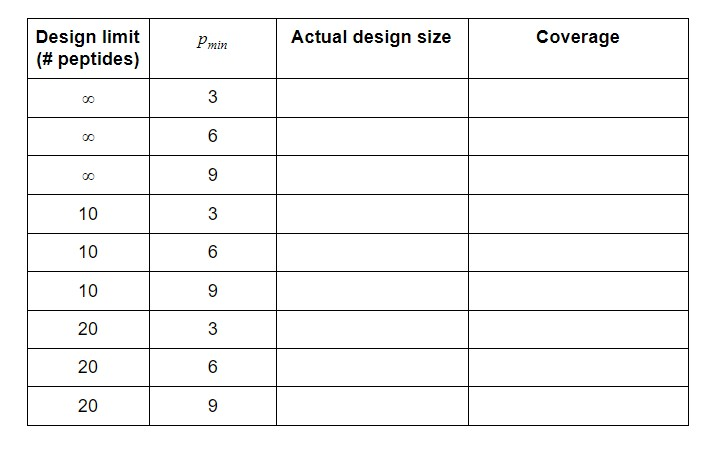

**MHC II Alleles**

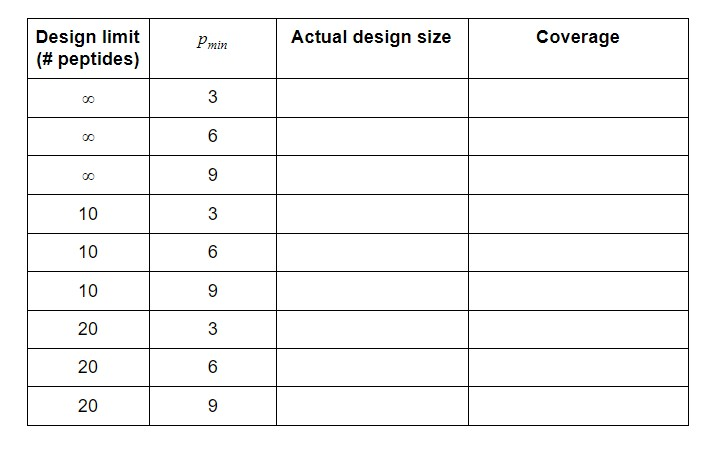


# Part 1.5

## Part 1.5: Work

In [ ]:
# TODO: 1. Determine criteria for selecting 20 peptides for your vaccine
#         (You do not need to have an equal number of peptides ‘covering’ MHC I and MHC II alleles)
#       2. Apply this criteria to obtain the required information for table in the cell below.      

## Part 1.5: Answer

Explain the criteria you used to select peptides: **YOUR EXPLANATION HERE**

What is the expected coverage of your design? **YOUR ANSWER HERE**

If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of above cell as long as it contains all of the relevant information.

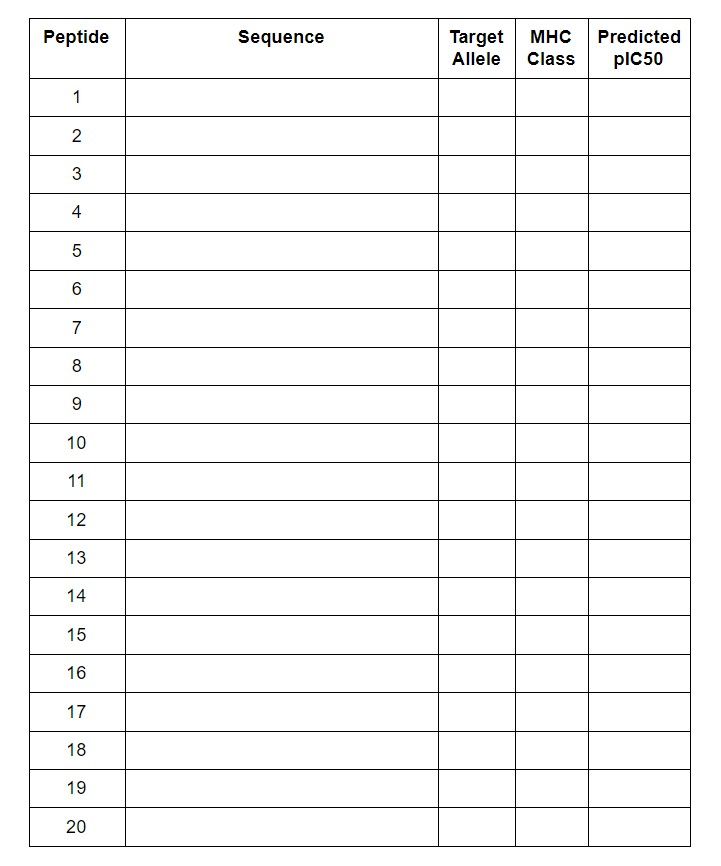

In [ ]:
# Ridge regression

from sklearn.linear_model import Ridge


def train_regression_model2(df,allele):

    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0]
    if rows > 0:
    
        clf = Ridge(alpha=1.0)
        return clf.fit(X,y)
    else:
        return None




def predict_pIC50_values2(allele_list, df, seq, k):
    
    results = []

    for allele in allele_list:
    
        # train model for this allele
        model = train_regression_model2(df,allele)
        
        # use model as long as it is not None
        if model:

            # use model to predict pIC50 for each k-mer in the sequence
            get_predictions(model,allele,seq,k,results)
        
    return results


In [ ]:
results_new = predict_pIC50_values2(class_i_list,MHC1_filtered_df,spike_sequence,9)

new_metrics = calculate_metrics('I',results_new)
new_metrics

In [ ]:
# Lasso regression

In [ ]:
# SVM nonlinear
from sklearn.svm import SVR

def train_regression_model4(df,allele):

    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0]
    if rows > 0:
    
        svr = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)
        return svr.fit(X,y)
    else:
        return None




def predict_pIC50_values4(allele_list, df, seq, k):
    
    results = []

    for allele in allele_list:
    
        # train model for this allele
        model = train_regression_model4(df,allele)
        
        # use model as long as it is not None
        if model:

            # use model to predict pIC50 for each k-mer in the sequence
            get_predictions(model,allele,seq,k,results)
        
    return results


In [ ]:
# takes too long
# results_new = predict_pIC50_values4(class_i_list,MHC1_filtered_df,spike_sequence,9)

# new_metrics = calculate_metrics('I',results_new)
# new_metrics

In [ ]:
# MLP

from sklearn.neural_network import MLPRegressor

def train_regression_model5(df,allele):

    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0]
    if rows > 0:
    
        regr = MLPRegressor(random_state=1, max_iter=500)
        return regr.fit(X,y)
    else:
        return None




def predict_pIC50_values5(allele_list, df, seq, k):
    
    results = []

    for allele in allele_list:
    
        # train model for this allele
        model = train_regression_model5(df,allele)
        
        # use model as long as it is not None
        if model:

            # use model to predict pIC50 for each k-mer in the sequence
            get_predictions(model,allele,seq,k,results)
        
    return results

In [ ]:
results_new = predict_pIC50_values5(class_i_list,MHC1_filtered_df,spike_sequence,9)

new_metrics = calculate_metrics('I',results_new)
new_metrics